In [2]:
import pandas as pd
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from IPython.html.widgets import interact
import seaborn
%matplotlib inline 

/homes/gws/kdorosch/software/anaconda2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# k-m experiments for Jaccard

The Jaccard index $\mathcal{J}$ on two sets $A$ and $B$ is defined as $$\mathcal{J}(A,B) = \frac{|A \cap B|}{|A \cup B|}$$

To estimate $\mathcal{J}(A,B)$, we use a minhashing scheme as follows. Given a random hash function $h$, $h(A) = \textrm{argmin}\{h(x) \mid x \in A\}$ by definition of minhashing. Given this, $P(h(A) = h(B)) = \mathcal{J}(A, B)$ which is our intended objective. 

To compute this, we use a locality-sensitive hashing scheme. We create $m$ blocks of size $k$, where each of the $m$ buckets contains $k$ minhashes. For $A$ and $B$ to be considered "similar" within the context of their Jaccard similarity $\mathcal{J}$ (that is, within some similarity $\epsilon$), ... 

Here we calculate $P(\textrm{some block} = \textrm{some block}) = 1 - (1 - \mathcal{J}(A, B)^k)^m$ and use this for tuning K and M. 


## Data
The data for this experiment is the [CORA](http://www.cs.utexas.edu/users/ml/riddle/data/cora.tar.gz) citation database from UCI's [SHERLOCK](http://sherlock.ics.uci.edu/data.html) project. It is a citation database with lots of related records, good for similarity join testing. 

## Approach (i think this is wrong)

As a proof-of-concept I will begin by defining record similarity on **just the title field** of the record, rather than the entire thing. The final analysis should include the entire record, but I chose a field for the purposes of understanding the concept. 

The outline of the apprach is as follows:

* Compute $n$-grams (*with what $n$?*) for all title fields in data. 
* Compute all-pairs Jaccard between all records (self-join).
* Plot $P(A, B) = 1 - (1 - \mathcal{J}(A, B)^k)^m$ for representative pair (?), with facility to choose k and m.



In [3]:
# from http://locallyoptimal.com/blog/2013/01/20/elegant-n-gram-generation-in-python/
def find_ngrams(input_list, n):
  return zip(*[input_list[i:] for i in range(n)])

cora_data = pd.DataFrame.from_csv("../data/cora/cora.txt", sep='\t', header=None)
cora_data['ngram_titles'] = cora_data[4].apply(find_ngrams, n=5)

## Another Idea:

Since the value of the Jaccard ranges from (0,1), I don't think we actually have to do any actuall Jaccard computation. We just need to explore the space of Jaccard and examine how the values of K and M interact with the probability of a chosen Jaccard value? 

**not sure about any of that** but below is a mechanism for computing it. 



<function __main__.interactfun>

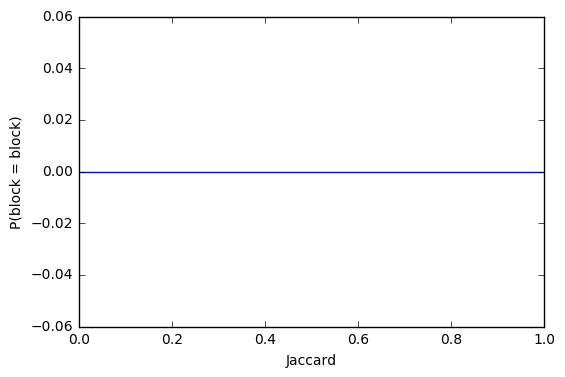

In [4]:
simspace = np.linspace(0, 1, 100)
def probsim(sim, k, m):
    # $P(A, B) = 1 - (1 - \mathcal{J}(A, B)^k)^m$ where $P(A,B) = \textrm{sim}$
    return 1 - (1 - sim**k)**m

def plot_probsim(sims, k, m):
    probsfunc = np.vectorize(partial(probsim, k=k, m=m))
    probs = probsfunc(sims);
    plt.plot(sims, probs)
    plt.ylabel("P(block = block)")
    plt.xlabel("Jaccard")
    

def interactfun(k, m):
    plot_probsim(simspace, k, m)
    
interact(interactfun, k=(0, 0.10,0.001), m=(0,1,0.01))


<function __main__.interactfun>

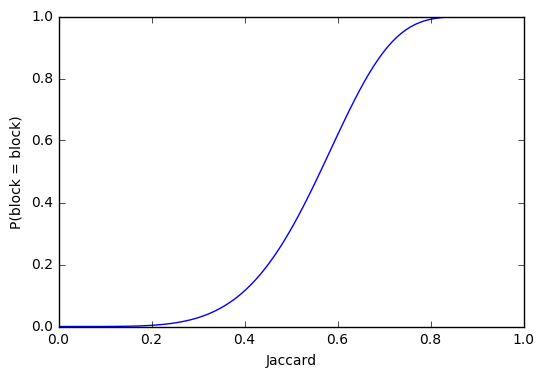

In [5]:
interact(interactfun, k=(0,10,1), m=(0,25,0.1))

#Something's not right

I get the sense here that something is still not perfect here––what makes this analysis for Jaccard different for the analyses of different algorithms? (nothing, currently). So I'm not sure we're there yet on this. 

In [68]:
goal_t = 0.8
def approx_threshold(k,m):
    return (1./m)**(1./k)


print "Try these values in the simulator:"
print "k\tm\th\tt"
for k in range(1,30):
    m = 1/goal_t**k
    print str(k) + "\t"+ str(m) + "\t" + str(k*m) + "\t" + str(approx_threshold(k,m))

Try these values in the simulator:
k	m	h	t
1	1.25	1.25	0.8
2	1.5625	3.125	0.8
3	1.953125	5.859375	0.8
4	2.44140625	9.765625	0.8
5	3.0517578125	15.2587890625	0.8
6	3.81469726562	22.8881835937	0.8
7	4.76837158203	33.3786010742	0.8
8	5.96046447754	47.6837158203	0.8
9	7.45058059692	67.0552253723	0.8
10	9.31322574615	93.1322574615	0.8
11	11.6415321827	128.05685401	0.8
12	14.5519152284	174.62298274	0.8
13	18.1898940355	236.468622461	0.8
14	22.7373675443	318.323145621	0.8
15	28.4217094304	426.325641456	0.8
16	35.527136788	568.434188608	0.8
17	44.408920985	754.951656745	0.8
18	55.5111512313	999.200722163	0.8
19	69.3889390391	1318.38984174	0.8
20	86.7361737988	1734.72347598	0.8
21	108.420217249	2276.82456222	0.8
22	135.525271561	2981.55597434	0.8
23	169.406589451	3896.35155737	0.8
24	211.758236814	5082.19768353	0.8
25	264.697796017	6617.44490042	0.8
26	330.872245021	8602.67837055	0.8
27	413.590306277	11166.9382695	0.8
28	516.987882846	14475.6607197	0.8
29	646.234853557	18740.8107532	0.8


In [11]:
def find_m(k,t):
    return 1/t**k

interact(find_m, k=(1,20,1), t=(0.01,1,0.01))

1024.0

<function __main__.find_m>

## Response to k-m experiments so far

I don't actually think anything is wrong.

See p.90 @ http://infolab.stanford.edu/~ullman/mmds/ch3.pdf 
"An approximation to the threshold is (1/b)^(1/r)." (where for us, r->k & b->m)

Say we want threshold t=0.7. We would then find k&m s.t. 0.7=(1/m)^(1/k)

They give the example threshold t~0.5, with b(aka m)=16 and r(aka k)=4.

We can specify a goal threshold t and aim to choose small values of k. (Reason: choosing small k reduces numerical instability because it is the innermost power which is then carried through the rest of the calculations.) This leaves us to solve for m:

$$t = \frac{1}{m}^{\frac{1}{k}}$$
$$log(t) = \frac{1}{k}log(\frac{1}{m})$$
$$k*log(t) = log(\frac{1}{m})$$
$$t^k = \frac{1}{m}$$
$$m = \frac{1}{t^k}$$


### The next question: is there a secondary property we want to optimize? 
#### S-curve should be steep
I imagine we would like the S-curve to have as steep of a slope as possible in the transition, as this would make the threshold cleaner. 

#### Is there a reason it shouldn't be steep?
A less steep slope would be able to differentiate around the threshold (but the threshold is firm so it shouldn't matter unless it affects the precision amongst the hashed probabilities or something).

A less steep slope (aka smaller k and correspondingly smaller m) decreases the risk of numerical instability with computation of powers.


Talk about in the paper:
lower threshold

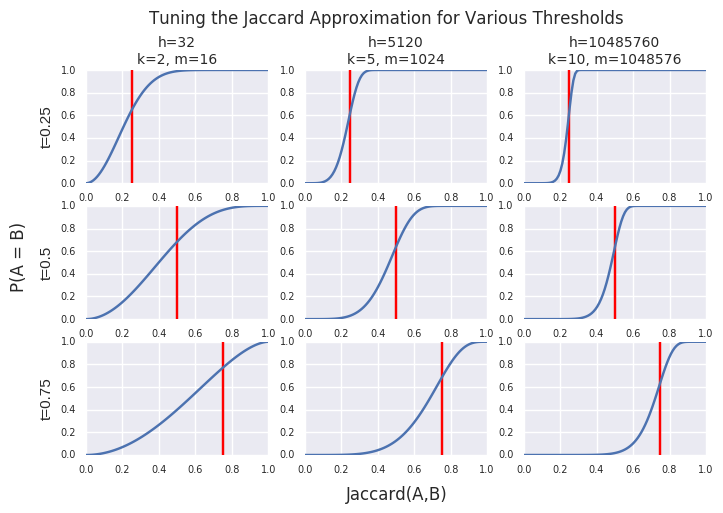

In [90]:
fig, ax = plt.subplots(3,3)
fig.subplots_adjust(bottom=0.2)
t = [0.25, 0.5, 0.75]
k = [2, 5, 10]
for row in range(3):
    for col in range(3):
        m = find_m(k[col], t[row])
        probs = probsim(simspace, k[col], m)
        ax[row, col].plot(simspace, probs)
        ax[row, col].vlines(t[row], 0, 1, colors='r')
        plt.setp(ax[row, col].get_xticklabels(), fontsize=7)
        plt.setp(ax[row, col].get_yticklabels(), fontsize=7)
        
        if row == 0:
            title = "h=" + str(int(k[col]*m)) + "\nk=" + str(k[col]) + ", m=" + str(int(m))
            ax[row, col].set_title(title, fontsize=10)
        if col == 0:
            ax[row, col].set_ylabel("t="+str(t[row]))#+", m={:.2}".format(m))
        # Where to label m??? Changes for every plot
#         ax[row, col].set_ylabel("P(block = block)")
#         ax[row, col].set_xlabel("Jaccard")
#         ax[row, col].set_title("t="+str(t[row])+", k="+str(k[col]))
fig.suptitle("Tuning the Jaccard Approximation for Various Thresholds", y=1.01)
fig.text(0.03, 0.6, "P(A = B)", rotation=90)
fig.text(0.45, 0.12, "Jaccard(A,B)")


fig.savefig("../plots/k-m_tradeoff.png", dpi=300, bbox_inches='tight')